<a href="https://colab.research.google.com/github/ThomasArtin/Weedbot/blob/main/weedbot_activeloop_dataset_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
in this notebook we convert the data from coco json to activeloop dataset
with the following schema :
WeedBot_schema = {
    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_width, 3)), 
    'bbox': Sequence(dtype = BBox()),
    'segmentation' : Sequence(dtype=Segmentation(shape=(None, None, 1), dtype='uint8', max_shape=(max_width, max_width, 1), names=['dauca'])),
}
each image has:
1) a sequence of bounding boxes for each inctance of weed detection
2) a sequence of one-hot binary masks for each instance of weeds detection
'''

"\nin this notebook we convert the data from coco json to activeloop dataset\nwith the following schema :\nWeedBot_schema = {\n    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_width, 3)), \n    'bbox': Sequence(dtype = BBox()),\n    'segmentation' : Sequence(dtype=Segmentation(shape=(None, None, 1), dtype='uint8', max_shape=(max_width, max_width, 1), names=['dauca'])),\n}\neach image has:\n1) a sequence of bounding boxes for each inctance of weed detection\n2) a sequence of one-hot binary masks for each instance of weeds detection\n"

In [ ]:
!pip3 install hub
!pip install pycocotools
#upload the kaggle.json file from choose files
from google.colab import files
import os
files.upload() #upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d pankajashankar/omdenaweedbot1
#unzip 
if not os.path.exists("/content/data"):
  os.mkdir("/content/data")
!unzip -q omdenaweedbot1.zip -d /content/data/

Saving kaggle.json to kaggle.json
 99% 1.56G/1.57G [00:50<00:00, 65.9MB/s]
100% 1.57G/1.57G [00:51<00:00, 33.0MB/s]


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import json
import hub
from hub import Dataset, schema
from hub.schema import Image,ClassLabel,Segmentation,BBox,Tensor,Sequence
from pycocotools.coco import COCO
import os

In [ ]:
!hub login

Please log in using Snark AI credentials. You can register at https://app.activeloop.ai 
Username: thomasartin
Password: 
Login Successful.


In [ ]:
for dirname, _, filenames in os.walk('/content/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/data/B2.json
/content/data/images/carot_2201.jpg
/content/data/images/carot_3082.jpg
/content/data/images/carot_2099.jpg
/content/data/images/carot_3060.jpg
/content/data/images/carot_2045.jpg
/content/data/images/carot_3024.jpg
/content/data/images/carot_3115.jpg
/content/data/images/carot_2026.jpg
/content/data/images/carot_2135.jpg
/content/data/images/carot_3180.jpg
/content/data/images/carot_2124.jpg
/content/data/images/carot_3183.jpg
/content/data/images/carot_3014.jpg
/content/data/images/carot_2246.jpg
/content/data/images/carot_3241.jpg
/content/data/images/carot_2055.jpg
/content/data/images/carot_2014.jpg
/content/data/images/carot_2204.jpg
/content/data/images/carot_3121.jpg
/content/data/images/carot_3101.jpg
/content/data/images/carot_3112.jpg
/content/data/images/carot_2247.jpg
/content/data/images/carot_2041.jpg
/content/data/images/carot_3164.jpg
/content/data/images/carot_2004.jpg
/content/data/images/carot_2064.jpg
/content/data/images/carot_2163.jpg
/conte

In [ ]:
#Data paths
json_file = '/content/data/B2.json'

images_PATH = '/content/data/images/'

In [ ]:
#load COCO json file
json_loaded = json.load(open(json_file, 'r'))
coco = COCO(json_file)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


[207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227]


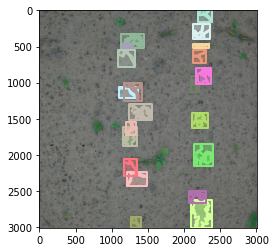

In [ ]:
#visualize the data
imageID = 13
annsIds = coco.getAnnIds(imgIds=[imageID])
anns = coco.loadAnns(annsIds)
print(annsIds)
image = (coco.loadImgs([imageID]))[0]
plt.imshow(cv.imread(images_PATH+image['file_name']))
coco.showAnns(anns,draw_bbox=True)

In [ ]:
#get max width and height for images, useful when creating schemas
def get_max_dims(json_loaded):
    heights = []
    widths = []
    max_height = 0
    max_width = 0
    for im in json_loaded['images']:
        height = int(im['height'])
        width = int(im['width'])
        heights.append(height)
        widths.append(width)
        max_height = max(heights)
        max_width = max(widths)
    return max_width,max_height
max_width,max_height = get_max_dims(json_loaded)
del json_loaded

In [ ]:
max_elements = 30
WeedBot_schema = {
    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_height, 3)), 
    'bbox': Sequence(dtype = BBox()),
    'segmentation': Segmentation(shape = (None,None),dtype='uint8',max_shape = (max_width,max_height),compressor = 'ZSTD'),
}
number_of_examples = len(coco.getImgIds())
print(number_of_examples)

500


In [ ]:
url = 'thomasartin/omdena-weedbot-dataset'
WeedBot_Dataset =Dataset(url,shape=(number_of_examples,), schema=WeedBot_schema)

/usr/local/lib/python3.6/dist-packages/zarr/creation.py:210: UserWarning: ignoring keyword argument 'mode'
  warn('ignoring keyword argument %r' % k)


In [ ]:
imgIDS = coco.getImgIds()
imgs = coco.loadImgs(imgIDS)

In [ ]:
for image_number in range(0,500):
    print('image number: {}'.format(image_number))
    image_file = images_PATH + imgs[image_number]['file_name']
    image = cv.imread(image_file)
    WeedBot_Dataset['image',image_number] = image
    annotationIDS = coco.getAnnIds(imgIDS[image_number])
    annotations = coco.loadAnns(annotationIDS)
    num_of_annotations = (len(annotationIDS))
    bboxes_array = np.zeros((num_of_annotations,4))
    mask = np.zeros((max_height,max_width))
    for annotation_number in range(num_of_annotations):
        annotation = annotations[annotation_number]
        mask = coco.annToMask(annotation)*(annotation_number+1) + mask
        bbox = annotation['bbox']
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0]+bbox[2]
        y2 = bbox[1]+bbox[3]
        bboxes_array[annotation_number,:] = np.array([x1,y1,x2,y2])
    print('number of annotations: {}'.format(num_of_annotations))
    WeedBot_Dataset['segmentation',image_number] = mask
    WeedBot_Dataset['bbox',image_number] = bboxes_array
    if ((image_number % 25) == 0):
      print('comitting')
      WeedBot_Dataset.commit()
      print('comitted successfully')


image number: 0
number of annotations: 16
comitting
comitted successfully
image number: 1
number of annotations: 14
image number: 2
number of annotations: 19
image number: 3
number of annotations: 13
image number: 4
number of annotations: 16
image number: 5
number of annotations: 16
image number: 6
number of annotations: 18
image number: 7
number of annotations: 17
image number: 8
number of annotations: 18
image number: 9
number of annotations: 21
image number: 10
number of annotations: 17
image number: 11
number of annotations: 21
image number: 12
number of annotations: 21
image number: 13
number of annotations: 22
image number: 14
number of annotations: 18
image number: 15
number of annotations: 18
image number: 16
number of annotations: 19
image number: 17
number of annotations: 17
image number: 18
number of annotations: 17
image number: 19
number of annotations: 21
image number: 20
number of annotations: 19
image number: 21
number of annotations: 20
image number: 22
number of annot

In [ ]:
'''
tutorial for understanding the schema:
every image has a sequence of bounding boxes
and in the same order of the bounding boxes the segmentation mask is made.
example :
for training example 0 
we have:
1) 1 image
2) 16 bounding boxes
3) 1 segmentation mask with the same size of the image that has pixel values from 0-16
pixel value of 0: anything that is not carrots
pixel value of 1: first carrot that corresponds to the first bounding box
....
pixel value of 16: carrot that corresponds to the first bounding box

active-loop link : https://app.activeloop.ai/dataset/thomasartin/omdena-weedbot-dataset
'''

'\ntutorial for understanding the schema:\nevery image has a sequence of bounding boxes\nand in the same order of the bounding boxes the segmentation mask is made.\nexample :\nfor training example 0 \nwe have:\n1) 1 image\n2) 16 bounding boxes\n3) 1 segmentation mask with the same size of the image that has pixel values from 0-16\npixel value of 0: anything that is not carrots\npixel value of 1: first carrot that corresponds to the first bounding box\n....\npixel value of 16: carrot that corresponds to the first bounding box\n\n'